## Uplift modeling experiments on CRITEO-UPLIFTv2 dataset

This code aims to:
- Show how to open and preprocess dataset
- Reproduce Table 3
- Reproduce Figure 3

In [32]:
import numpy as np
import pandas as pd
from tqdm import tqdm
%pylab inline
plt.rcParams.update(plt.rcParamsDefault)
import joblib

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import normalize, OneHotEncoder
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold, MultilabelStratifiedShuffleSplit

from um_util import *
from um_models import *

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Open the dataset

In [2]:
# please download data from: 
# http://go.criteo.net/criteo-research-uplift-v2.1.csv.gz

inp_df = pd.read_csv('../../criteo-research-uplift-v2.1.csv.gz')

features = ['f{}'.format(n) for n in range(12)]
inp_df[features] = normalize(inp_df[features], axis=0, norm='l2')

X = features
y = 'visit'
t = 'treatment'

In [3]:
cat_features = ['f1', 'f3', 'f4', 'f5', 'f6', 'f8', 'f9', 'f11']
noncat_features = list(inp_df.columns.difference(cat_features + [y,t,'conversion', 'exposure']))

shuffle the data

In [4]:
np.random.seed(111)
df = inp_df.sample(frac=1).reset_index(drop=True)

Create stritified splits

In [5]:
msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=0)

trval_i, test_i = next(msss.split(df.loc[:,X].values, df.loc[:,[y,t]].values))

### Learnability test

In [6]:
ll_dummy = log_loss(df.loc[test_i, y], np.mean(df.loc[trval_i, y])*np.ones_like(df.loc[test_i, y]))
ll_logreg = log_loss(df.loc[test_i, y], LogisticRegression(C=1e8).fit(df.loc[trval_i, X], df.loc[trval_i, y]).predict_proba(df.loc[test_i, X])[:,1])

In [7]:
ll_dummy, ll_logreg

(0.18956144974634445, 0.12370658549012369)

In [34]:
print(f'Improvement of learning visits over dummy model: {100. * (1 - ll_logreg / ll_dummy):.2f}')

Improvement of learning visits over dummy model: 34.74


In [9]:
ll_dummy_conv = log_loss(df.loc[test_i, 'conversion'], np.mean(df.loc[trval_i, 'conversion'])*np.ones_like(df.loc[test_i, 'conversion']))
ll_logreg_conv = log_loss(df.loc[test_i, 'conversion'], LogisticRegression(C=1e8).fit(df.loc[trval_i, X], df.loc[trval_i, 'conversion']).predict_proba(df.loc[test_i, X])[:,1])

In [10]:
ll_dummy_conv, ll_logreg_conv

(0.01990501589150957, 0.013492372810905543)

In [35]:
print(f'Improvement of learning conversions over dummy model: {100. * (1 - ll_logreg_conv / ll_dummy_conv):.2f}')

Improvement of learning conversions over dummy model: 32.22


### Treatment independence test

In [12]:
c2st_res = c2st(df[X], df[t], clf=LogisticRegression(), loss=log_loss, bootstraps=300)

100%|██████████| 300/300 [53:24<00:00, 10.68s/it]


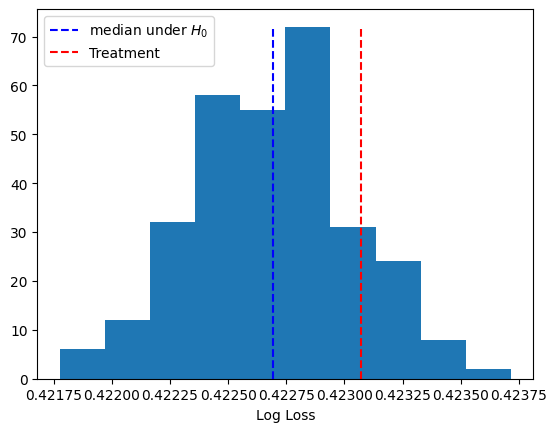

In [13]:
bins, _, __ = plt.hist(c2st_res[1])
med = np.median(c2st_res[1])
plt.plot((med,med),(0, max(bins)), 'b--', label='median under $H_0$')
plt.plot((c2st_res[0],c2st_res[0]),(0, max(bins)), 'r--', label='Treatment')
plt.xlabel('Log Loss')

plt.legend()
plt.show()

In [31]:
print(f'Median Random Loss: {np.median(c2st_res[1]):.5f}, Treatment Loss: {c2st_res[0]:.5f}, p-value: {c2st_res[2]:.5f}')

Median Random Loss: 0.42269, Treatment Loss: 0.42307, p-value: 0.13667


### Preprocessing: hashing + OneHot encoding

In [15]:
X_cat_hash = df[cat_features].copy()
for f in cat_features:
    X_cat_hash[f] = df[f].astype('str')      
hasher = FeatureHasher(n_features=100, input_type='string')
X_cat_hash_sparse = hasher.transform(X_cat_hash.values)

In [16]:
ohe = OneHotEncoder(sparse=0, handle_unknown='ignore')
X_cat_hash_ohe = ohe.fit_transform(X_cat_hash_sparse.toarray())
X_hash_ohe = np.hstack((df[noncat_features].values, X_cat_hash_ohe))

In [17]:
ohe_sparse = OneHotEncoder(sparse=1, handle_unknown='ignore')
X_cat_hash_ohe_sparse = ohe_sparse.fit_transform(X_cat_hash_sparse.toarray())
X_hash_ohe_sparse = sparse.hstack((sparse.csr_matrix(df[noncat_features].values), X_cat_hash_ohe_sparse), format='csr')

### Hyperparameter tuning

Two-Model (TM)

In [18]:
tm_params = {
    'C':[1e8, 1e6, 1e4, 1e2, 1e0]
}

In [19]:
tm_tuning = GridSearchCV(
    TMEstimator(),
    tm_params,
    cv=mskf,
    n_jobs=1
)

tm_tuning.fit(
    X_hash_ohe[trval_i],
    df.loc[trval_i, [y,t]].values
)

joblib.dump(tm_tuning.best_estimator_, 'tm_best_estimator.pkl', compress = 1)

['tm_best_estimator.pkl']

Class Variable Transformation (CVT)

In [20]:
cvt_params = {
    'C':[1e8, 1e6, 1e4, 1e2, 1e0]
}

In [21]:
cvt_tuning = GridSearchCV(
    CVTEstimator(),
    cvt_params,
    cv=mskf,
    n_jobs=1
)

cvt_tuning.fit(
    X_hash_ohe[trval_i],
    df.loc[trval_i, [y,t]].values
)

joblib.dump(cvt_tuning.best_estimator_, 'cvt_best_estimator.pkl', compress = 1)

['cvt_best_estimator.pkl']

Modified Outcome Method (MOM)

In [22]:
mom_params = {
    'alpha':[1e-8, 1e-6, 1e-4, 1e-2, 1e0]
}

In [23]:
mom_tuning = GridSearchCV(
    MOMEstimator(),
    mom_params,
    cv=mskf,
    n_jobs=1
)

mom_tuning.fit(
    X_hash_ohe[trval_i],
    df.loc[trval_i, [y,t]].values
)

joblib.dump(mom_tuning.best_estimator_, 'mom_best_estimator.pkl', compress = 1)

['mom_best_estimator.pkl']

Shared Data Representation (SDR)

In [24]:
sdr_params = {
    'C':[1e3, 1e2, 1e1, 1e0],
    'reg':[1e-1, 1e0],
    'sparse':[True]
}

In [25]:
sdr_tuning = GridSearchCV(
    SDREstimator(),
    sdr_params,
    cv=mskf,
    n_jobs=1
)

sdr_tuning.fit(
    X_hash_ohe_sparse[trval_i],
    df.loc[trval_i, [y,t]].values
)

joblib.dump(sdr_tuning.best_estimator_, 'sdr_best_estimator.pkl', compress = 1)

['sdr_best_estimator.pkl']

### Estimate performance on test data

In [26]:
test_sizes = [1000, 5000, 50000, 1000000, len(test_i)]
tm_res, cvt_res, mom_res, sdr_res = [],[],[],[]

for size in tqdm(test_sizes):
    if size == len(test_i):
        bsln_test_i = test_i
    else:
        msss_test = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=float(size)/len(test_i), random_state=0)
        _, bsln_test_i = next(msss_test.split(df.loc[test_i,X].values, df.loc[test_i,[y,t]].values))
    
    tm_best_estimator = joblib.load('tm_best_estimator.pkl')
    tm_test_auuc = tm_best_estimator.score(X_hash_ohe[bsln_test_i][:], df.loc[bsln_test_i, [y,t]].values[:])
    tm_ci = auuc_test_set_bound_bern(df.loc[bsln_test_i, y].values[:], df.loc[bsln_test_i, t].values[:], tm_best_estimator.predict_uplift(X_hash_ohe[bsln_test_i][:]), 0.05)
    tm_res.append([tm_test_auuc, tm_ci])
    
    cvt_best_estimator = joblib.load('cvt_best_estimator.pkl')
    cvt_test_auuc = cvt_best_estimator.score(X_hash_ohe[bsln_test_i][:], df.loc[bsln_test_i, [y,t]].values[:])
    cvt_ci = auuc_test_set_bound_bern(df.loc[bsln_test_i, y].values[:], df.loc[bsln_test_i, t].values[:], cvt_best_estimator.predict_uplift(X_hash_ohe[bsln_test_i][:]), 0.05)
    cvt_res.append([cvt_test_auuc, cvt_ci])
    
    mom_best_estimator = joblib.load('mom_best_estimator.pkl')
    mom_test_auuc = mom_best_estimator.score(X_hash_ohe[bsln_test_i][:], df.loc[bsln_test_i, [y,t]].values[:])
    mom_ci = auuc_test_set_bound_bern(df.loc[bsln_test_i, y].values[:], df.loc[bsln_test_i, t].values[:], mom_best_estimator.predict_uplift(X_hash_ohe[bsln_test_i][:]), 0.05)
    mom_res.append([mom_test_auuc, mom_ci])
    
    sdr_best_estimator = joblib.load('sdr_best_estimator.pkl')
    sdr_test_auuc = sdr_best_estimator.score(X_hash_ohe_sparse[bsln_test_i][:], df.loc[bsln_test_i, [y,t]].values[:])
    sdr_ci = auuc_test_set_bound_bern(df.loc[bsln_test_i, y].values[:], df.loc[bsln_test_i, t].values[:], sdr_best_estimator.predict_uplift(X_hash_ohe_sparse[bsln_test_i][:]), 0.05)
    sdr_res.append([sdr_test_auuc, sdr_ci])

100%|██████████| 5/5 [09:44<00:00, 116.81s/it]


### Results

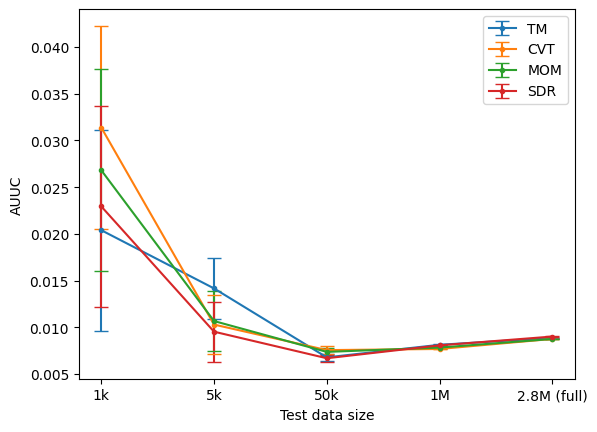

In [27]:
Ns = ['1k', '5k', '50k', '1M', str(round(len(test_i)/1e6,1)) +'M (full)']
k = 5
plt.errorbar(np.arange(len(Ns[-k:])), [i[0] for i in tm_res[-k:]], yerr=[i[1] for i in tm_res[-k:]], marker='.', capsize=5, label='TM')
plt.errorbar(np.arange(len(Ns[-k:])), [i[0] for i in cvt_res[-k:]], yerr=[i[1] for i in cvt_res[-k:]], marker='.', capsize=5, label='CVT')
plt.errorbar(np.arange(len(Ns[-k:])), [i[0] for i in mom_res[-k:]], yerr=[i[1] for i in mom_res[-k:]], marker='.', capsize=5, label='MOM')
plt.errorbar(np.arange(len(Ns[-k:])), [i[0] for i in sdr_res[-k:]], yerr=[i[1] for i in sdr_res[-k:]], marker='.', capsize=5, label='SDR')

plt.xticks(np.arange(len(Ns[-k:])), Ns[-k:])
# plt.xlabel('')
plt.xlabel('Test data size')
plt.ylabel('AUUC')
plt.legend()
plt.show()

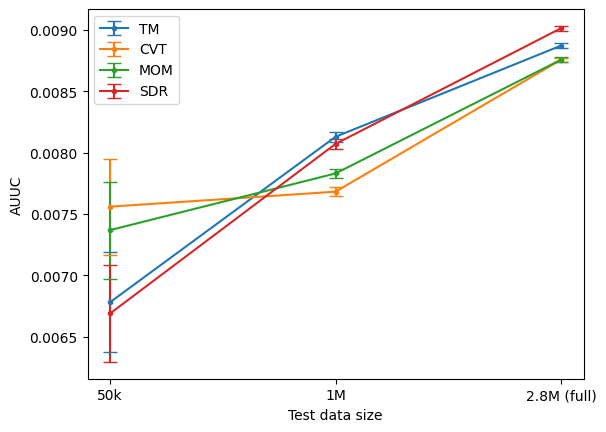

In [28]:
Ns = ['1k', '5k', '50k', '1M', str(round(len(test_i)/1e6,1)) +'M (full)']
k = 3
plt.errorbar(np.arange(len(Ns[-k:])), [i[0] for i in tm_res[-k:]], yerr=[i[1] for i in tm_res[-k:]], marker='.', capsize=5, label='TM')
plt.errorbar(np.arange(len(Ns[-k:])), [i[0] for i in cvt_res[-k:]], yerr=[i[1] for i in cvt_res[-k:]], marker='.', capsize=5, label='CVT')
plt.errorbar(np.arange(len(Ns[-k:])), [i[0] for i in mom_res[-k:]], yerr=[i[1] for i in mom_res[-k:]], marker='.', capsize=5, label='MOM')
plt.errorbar(np.arange(len(Ns[-k:])), [i[0] for i in sdr_res[-k:]], yerr=[i[1] for i in sdr_res[-k:]], marker='.', capsize=5, label='SDR')

plt.xticks(np.arange(len(Ns[-k:])), Ns[-k:])
# plt.xlabel('')
plt.xlabel('Test data size')
plt.ylabel('AUUC')
plt.legend()
plt.show()